## Image segmentation with Unreal generated data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image

In [3]:
path = Path('data/imageSeg')
path.ls()

[PosixPath('data/imageSeg/codes.txt'),
 PosixPath('data/imageSeg/images'),
 PosixPath('data/imageSeg/valid.txt'),
 PosixPath('data/imageSeg/test.png'),
 PosixPath('data/imageSeg/valid_mask.txt'),
 PosixPath('data/imageSeg/steeringValues.csv'),
 PosixPath('data/imageSeg/steeringValues_pred.csv'),
 PosixPath('data/imageSeg/labels'),
 PosixPath('data/imageSeg/.ipynb_checkpoints'),
 PosixPath('data/imageSeg/regression_images'),
 PosixPath('data/imageSeg/temp.png')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/imageSeg/images/ScreenShot01872.png'),
 PosixPath('data/imageSeg/images/ScreenShot00956.png'),
 PosixPath('data/imageSeg/images/ScreenShot01508.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/imageSeg/labels/ScreenShot01303_P.png'),
 PosixPath('data/imageSeg/labels/ScreenShot00674_P.png'),
 PosixPath('data/imageSeg/labels/ScreenShot02570_P.png')]

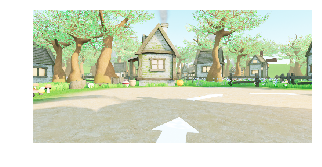

In [7]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

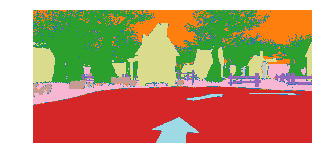

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([361, 760]), tensor([[[1, 1, 0,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Void', 'Sky', 'Tree', 'Road', 'Fence', 'Object_stationary', 'Grass', 'Lightpost', 'House', 'Arrow'],
      dtype='<U17')

## Datasets

In [12]:
size = src_size//2
bs=4

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(do_flip=False, max_rotate=0.0, max_zoom=0.0, max_warp=0.0), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

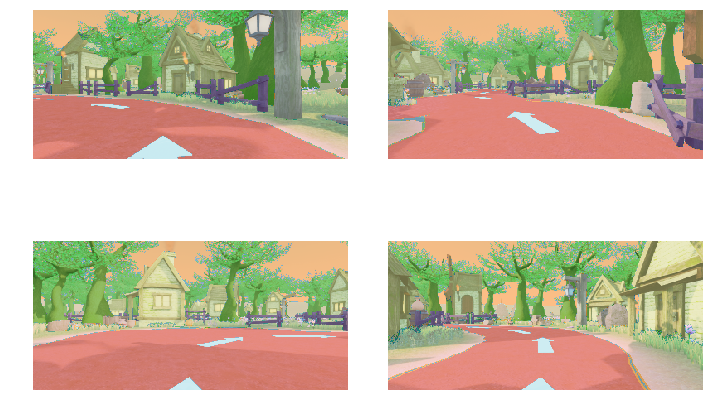

In [15]:
data.show_batch(2, figsize=(10,7))

In [16]:
data.valid_ds

LabelList (652 items)
x: SegmentationItemList
Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380)
y: SegmentationLabelList
ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380)
Path: data/imageSeg/images

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid

In [19]:
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


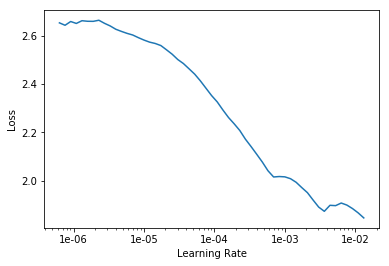

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr=1e-4

In [31]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.282715,0.394477,0.920737,03:25
2,0.271369,0.388126,0.925360,03:30
3,0.230365,0.343492,0.934017,03:30
4,0.210497,0.345755,0.939469,03:30
5,0.186406,0.330791,0.945554,03:31


In [30]:
doc(learn.fit_one_cycle)

In [32]:
learn.save('stage-1')

In [21]:
learn.load('stage-1');

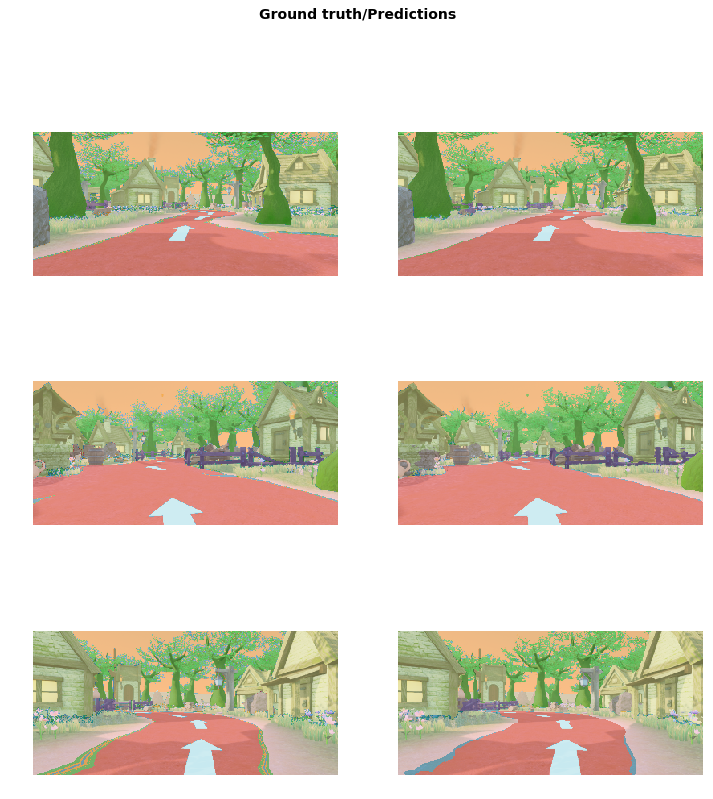

In [22]:
learn.show_results(rows=3, figsize=(12,13))

In [34]:
learn.unfreeze()

In [35]:
lrs = slice(lr/400,lr/4)

In [36]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.189695,0.322922,0.945916,03:46
2,0.181187,0.339909,0.944845,03:49
3,0.177565,0.330056,0.946302,03:49
4,0.173442,0.334022,0.946261,03:49
5,0.172290,0.346988,0.946277,03:49


In [37]:
learn.save('stage-2')

In [20]:
learn.load('stage-2');

Learner(data=ImageDataBunch;

Train: LabelList (1664 items)
x: SegmentationItemList
Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380)
y: SegmentationLabelList
ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380)
Path: data/imageSeg/images;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380),Image (3, 180, 380)
y: SegmentationLabelList
ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380),ImageSegment (1, 180, 380)
Path: data/imageSeg/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
     

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [38]:
size = src_size
bs=3
print(size)

[361 760]


In [39]:
data = (src.transform(get_transforms(do_flip=False, max_rotate=0.0, max_zoom=0.0, max_warp=0.0), size=[360, 760], tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [40]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [20]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


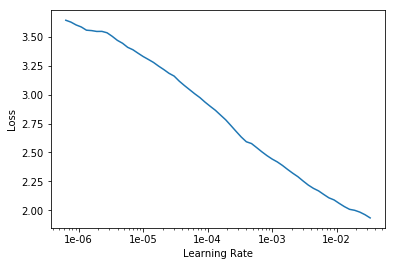

In [41]:
lr_find(learn)
learn.recorder.plot()

In [42]:
lr=1e-4

In [43]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.324175,0.409549,0.917683,13:40
2,0.244534,0.298039,0.945601,13:39
3,0.180087,0.263777,0.953354,13:41


In [44]:
learn.save('stage-1-big')

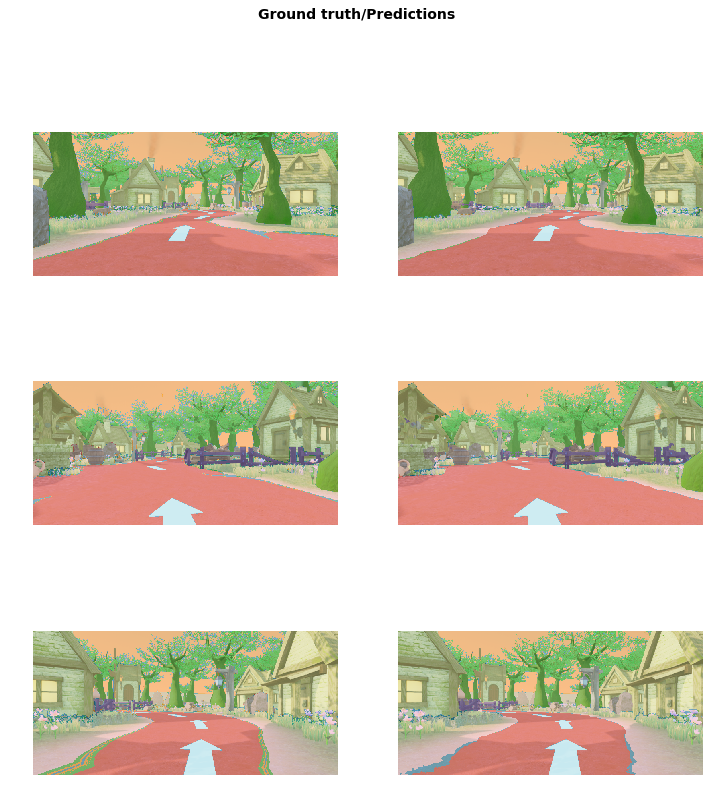

In [45]:
learn.show_results(rows=3, figsize=(12,13))

In [23]:
learn.load('stage-1-big');

In [46]:
learn.unfreeze()

In [47]:
lrs = slice(1e-6,lr/10)

In [48]:
learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.166567,0.273983,0.954100,14:12
2,0.157886,0.273904,0.954641,14:19
3,0.159125,0.273987,0.954605,14:19


In [49]:
learn.save('stage-2-big')

In [22]:
learn.load('stage-2-big');

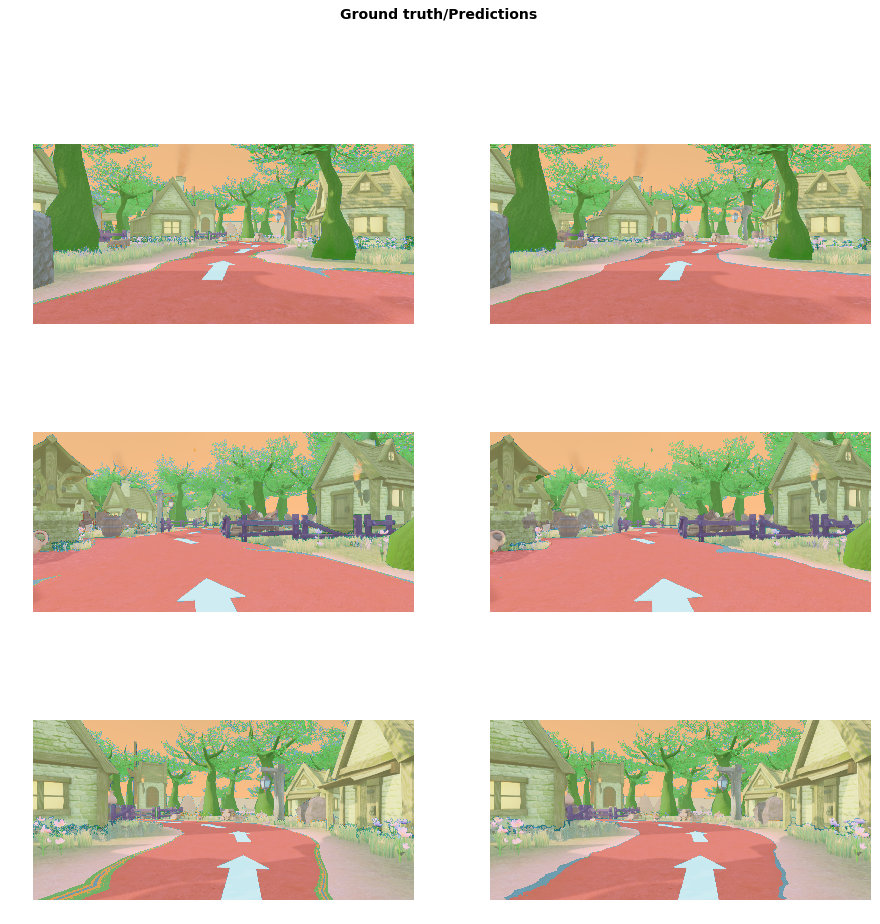

In [50]:
learn.show_results(rows=3, figsize=(15, 15))

## Predict

In [23]:
img = open_image('data/imageSeg/images/ScreenShot02750.png')
pred_class,pred_label,outputs = learn.predict(img)
print(pred_class.data)
x = image2np(pred_class.data*28).astype(np.uint8)
PIL.Image.fromarray(x).save('data/imageSeg/test.png')

tensor([[[1, 2, 1,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [1, 2, 2,  ..., 2, 2, 2],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]])


In [24]:
learn.export('export_imageSeg.pkl')